# Importando bibliotecas e dataset 

In [1]:
# Adicionando ao path para facilitar importações de arquivos
import sys
sys.path.append('../')

In [2]:
# Descomente a linha abaixo na primeira execução, caso não possua o `pt_core_news_lg`
# !python -m spacy download pt_core_news_lg

In [3]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import openai
import pandas as pd
import re
import seaborn as sns
import spacy
import string

from LeIA import SentimentIntensityAnalyzer as LeIASentimentIntensityAnalyzer
from nltk.sentiment import SentimentIntensityAnalyzer
from spacy.lang.pt.stop_words import STOP_WORDS
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tqdm import tqdm

import pt_core_news_lg

pd.options.display.max_colwidth = 100

In [4]:
file_path = '../data/raw/ErikakHilton-tweets.csv'
df = pd.read_csv(file_path, on_bad_lines='skip', sep=';', encoding='utf-8')

/tmp/ipykernel_8170/3505034139.py:2: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, on_bad_lines='skip', sep=';', encoding='utf-8')


In [5]:
df.shape

(22505, 49)

# Pré processamento

## Filtrar tweets
Vamos remover tweets repetidos e filtrar uma amostra menor, para facilitar a comparação manual de resultados

In [6]:
duplicated_indexes = df[df.duplicated()].index
sample_df = df.drop(duplicated_indexes)
sample_df.shape

(20505, 49)

In [7]:
sample_df = sample_df[:100]

## Limpeza dos tweets

In [8]:
# Removendo "não" das stopwords
STOP_WORDS.remove('não')

# Instanciando spacy/pt_core_news_lg - corpus completo
nlp = spacy.load('pt_core_news_lg')

In [9]:
# Função para remover URL
def remover_url(texto):
    texto = re.sub(r'http\S+', '', texto)
    return texto

# Função para remover contas
def remover_twiters(texto):
    texto = re.sub(r'@\w+', '', texto)
    return texto

# Função para remover pontuações
def remover_pontuacao(texto):
    texto = re.sub(f"[{re.escape(string.punctuation)}]", "", texto)
    return texto

# Função para remoção de stopwords e digitos
def limpar_texto(texto):
    doc = nlp(texto)
    tokens = [token.text for token in doc if not token.is_stop and not token.is_digit]
    texto_limpo = " ".join(tokens)
    return texto_limpo

In [10]:
# Aplicando limpezas
tweets = sample_df['rawContent']

tweets = tweets.str.lower()
tweets = tweets.apply(remover_url)
tweets = tweets.apply(remover_twiters)
tweets = tweets.apply(remover_pontuacao)
tweets = tweets.apply(limpar_texto)

In [11]:
# Jogando de volta para o dataframe
sample_df['formatted_content'] = tweets

In [12]:
sample_df[['rawContent', 'formatted_content']].head()

,rawContent,formatted_content
0,"Ao longo do dia estou recebendo denúncias, inclusive de pessoas presas há mais de 16h na estrada...",longo dia recebendo denúncias pessoas presas há 16h estrada água comida bloqueios ilegais caminh...
1,@ErikakHilton Simplesmente a maior ❤️❤️❤️ https://t.co/SBA5EPiN7k,simplesmente ❤ ️ ❤ ️ ❤ ️
2,@PalasAthenas18 Hahahhaha 💜💜💜,hahahhaha 💜 💜 💜
4,@ErikakHilton É isso aí...,
5,@Mendes2588 🫶🏾🫶🏾,🫶🏾🫶🏾


## Lemmatizando

In [13]:
# Função para lemmatização
def lemmatiza(texto):
    doc = nlp(texto)
    lemmatized_tokens = []
    for token in doc:
        lemmatized_tokens.append(token.lemma_)
    return " ".join(lemmatized_tokens)

In [14]:
sample_df['lemma_content'] = sample_df['formatted_content'].apply(lemmatiza)

In [15]:
sample_df[['rawContent', 'formatted_content', 'lemma_content']].head()

,rawContent,formatted_content,lemma_content
0,"Ao longo do dia estou recebendo denúncias, inclusive de pessoas presas há mais de 16h na estrada...",longo dia recebendo denúncias pessoas presas há 16h estrada água comida bloqueios ilegais caminh...,longo dia receber denúncia pessoa presas haver 16h estrada água comer bloqueio ilegal caminhonei...
1,@ErikakHilton Simplesmente a maior ❤️❤️❤️ https://t.co/SBA5EPiN7k,simplesmente ❤ ️ ❤ ️ ❤ ️,simplesmente ❤ ️ ❤ ️ ❤ ️
2,@PalasAthenas18 Hahahhaha 💜💜💜,hahahhaha 💜 💜 💜,hahahhaha 💜 💜 💜
4,@ErikakHilton É isso aí...,,
5,@Mendes2588 🫶🏾🫶🏾,🫶🏾🫶🏾,🫶🏾🫶🏾


# Análise de Sentimento

## Vader Sentiment Intensity Analysis
O Vader (do NLTK) não foi treinado com português, portanto seus resultados não são confiáveis. Vamos aplicar aqui apenas para comparar com o LeIA

In [16]:
nltk.download('vader_lexicon') # download do sentiment lexicon

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/paim/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [17]:
vader_sia = SentimentIntensityAnalyzer()

def vader_sentiment_analysis(text):
    return vader_sia.polarity_scores(text)['compound']

sample_df['vader_sentiment_score'] = sample_df['rawContent'].apply(vader_sentiment_analysis)

## LeIA Sentiment Intensity Analysis

LeIA (Léxico para Inferência Adaptada) é uma adaptação da analise de intensidade de sentimento do Vader para o português

In [20]:
leia_sia = LeIASentimentIntensityAnalyzer() # criar sentiment analyzer

def leia_sentiment_analysis(text):
    return leia_sia.polarity_scores(text)

scores = sample_df['rawContent'].apply(leia_sentiment_analysis)
sample_df['leia_sentiment_neg'] = scores.apply(lambda score: score['neg'])
sample_df['leia_sentiment_neu'] = scores.apply(lambda score: score['neu'])
sample_df['leia_sentiment_pos'] = scores.apply(lambda score: score['pos'])
sample_df['leia_sentiment_score'] = scores.apply(lambda score: score['compound'])

# Score com texto lemmatizado, para comparação
lemma_scores = sample_df['lemma_content'].apply(leia_sentiment_analysis)
sample_df['lemma_leia_sentiment_score'] = lemma_scores.apply(lambda score: score['compound'])

## Avaliação do ChatGPT
Vamos usar a API do ChatGPT para gerar outra análise de sentimentos, para comparar os resultados.

In [21]:
from src.config import OPENAI_API_KEY
openai.api_key = OPENAI_API_KEY

In [ ]:
"""
Estava tentando um resultado mais elaborado, mas as respostas estão muito inconsistentes. 
Acho que vale a pena tentar otimizar os prompts para respostas mais precisas e bem explicadas
"""
# base_msg = (
#     "Você é meu assistente de PLN e fará uma análise de sentimentos nos tweets que eu mandar. "
#     "Os tweets serão enviados no formato CSV com duas colunas (separadas por ;;):\n - Id do tweet\n - Texto do tweet\n\n"
#     "Para cada tweet você deve gerar um score de -1 (extremamente negativo) a 1(extremamente positivo), com até 4 casas decimais.\n"
#     "Sua resposta deve vir no formato de um arquivo CSV com três colunas (separadas por ;;):\n"
#     " - Id do tweet\n - Score de sentimentos do tweet\n - Breve explicação do score\n\n"
#     "Aqui vão os tweets para análise:\n"
# )

# def get_chatgpt_tweet_input(tweet):
#     return f"{tweet.id};;{tweet.rawContent}"

# tweets_input = sample_df[:10].apply(get_chatgpt_row_input, axis=1).values
# tweets_input = '\n'.join(tweets_input)

# msg = base_msg + tweets_input
# print(msg)
# print('\n\n')

# completion = openai.ChatCompletion.create(
#     model="gpt-3.5-turbo",
#     messages=[{"role": "user", "content": msg}],
#     temperature=0,
# )

# print(completion.choices[0].message.content)

In [27]:
base_msg = (
    "Você é meu assistente de PLN e irá realizar uma análise de sentimentos no tweet que eu enviar. "
    "Você deve gerar um score de sentimento de -1 (extremamente negativo) a 1(extremamente positivo), com até 4 casas decimais. "
    "Sua resposta deve conter apenas o número do score de sentimento."
    "Tweet: "
)

raw_chatgpt_sentiment_score = []

for tweet in tqdm(sample_df['rawContent']):
    msg = base_msg + tweet    
    completion = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[{"role": "user", "content": msg}],
        temperature=0,
    )

    raw_chatgpt_sentiment_score.append(completion.choices[0].message.content)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:23<00:00,  1.19it/s]


In [29]:
# O ChatGPT não consegue avaliar alguns tweets, por isso precisamos remover alguns dos resultados
def convert_score(raw_score):
    try:
        return float(score)
    except Exception as e:
        return None

chatgpt_sentiment_score = []
for score in raw_chatgpt_sentiment_score:
    chatgpt_sentiment_score.append(convert_score(score))
    
sample_df['chatgpt_sentiment_score'] = chatgpt_sentiment_score

In [30]:
def get_sentiment_from_score(score):
    if score <= -0.5:
        return "neg"
    if score < 0.5:
        return "neu"
    return "pos"

sample_df['chatgpt_sentiment'] = sample_df['chatgpt_sentiment_score'].apply(get_sentiment_from_score)
sample_df['chatgpt_sentiment'].value_counts()

pos    40
neu    33
neg    27
Name: chatgpt_sentiment, dtype: int64

# Comparação de Resultados

In [ ]:
print(sample_df['vader_sentiment_score'].hist())

In [ ]:
print(sample_df['lemma_leia_sentiment_score'].hist())

In [ ]:
print(sample_df['leia_sentiment_score'].hist())

In [ ]:
print(sample_df['chatgpt_sentiment_score'].hist())

In [ ]:
sample_df[['rawContent', 'lemma_content', 'vader_sentiment_score', 'lemma_leia_sentiment_score', 'leia_sentiment_score', 'chatgpt_sentiment_score']]

In [ ]:
sample_df[['vader_sentiment_score', 'lemma_leia_sentiment_score', 'leia_sentiment_score', 'chatgpt_sentiment_score']].describe()

### Métricas

In [ ]:
# Necessário remover as linhas com None para calcular o erro
results_df = sample_df.dropna(subset=['leia_sentiment_score', 'chatgpt_sentiment_score'])

# Calculando métricas da análise
mae = mean_absolute_error(
    results_df['chatgpt_sentiment_score'], 
    results_df['leia_sentiment_score']
)
lemma_mae = mean_absolute_error(
    results_df['chatgpt_sentiment_score'], 
    results_df['lemma_leia_sentiment_score']
)

mse = mean_squared_error(
    results_df['chatgpt_sentiment_score'], 
    results_df['leia_sentiment_score']
)
lemma_mse = mean_squared_error(
    results_df['chatgpt_sentiment_score'], 
    results_df['lemma_leia_sentiment_score']
)

r2 = r2_score(
    results_df['chatgpt_sentiment_score'], 
    results_df['leia_sentiment_score']
)
lemma_r2 = r2_score(
    results_df['chatgpt_sentiment_score'], 
    results_df['lemma_leia_sentiment_score']
)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R2: {r2}")

print(f"Lemma MAE: {lemma_mae}")
print(f"Lemma MSE: {lemma_mse}")
print(f"Lemma R2: {lemma_r2}")

In [ ]:
# Comparando analises do LeIA com e sem tratamento
comp_mae = mean_absolute_error(
    results_df['leia_sentiment_score'], 
    results_df['lemma_leia_sentiment_score']
)

comp_mse = mean_squared_error(
    results_df['leia_sentiment_score'], 
    results_df['lemma_leia_sentiment_score']
)

comp_r2 = r2_score(
    results_df['leia_sentiment_score'], 
    results_df['lemma_leia_sentiment_score']
)

print(f"{comp_mae=}")
print(f"{comp_mse=}")
print(f"{comp_r2=}")

In [ ]:
O LeIA não requer pré-processamento, mas calculamos apenas para confirmar. Como o resultado da analise com texto lematizado foi pior, confirmamos a hipótese.

## Analisando resultados do LeIA

In [22]:
# Checando quantas linhas não tiveram nenhum token por valencia
print(sample_df[sample_df['leia_sentiment_neg'] == 0].shape[0])
print(sample_df[sample_df['leia_sentiment_neu'] == 0].shape[0])
print(sample_df[sample_df['leia_sentiment_pos'] == 0].shape[0])

73
0
65


In [ ]:
sample_df['abs_leia_error'] = abs(sample_df['chatgpt_sentiment_score'] - sample_df['leia_sentiment_score'])

print(sample_df['abs_leia_error'].describe())
sample_df['abs_leia_error'].hist()

### Distribuição da quantidade de palavras

<Axes: xlabel='word_count', ylabel='Count'>

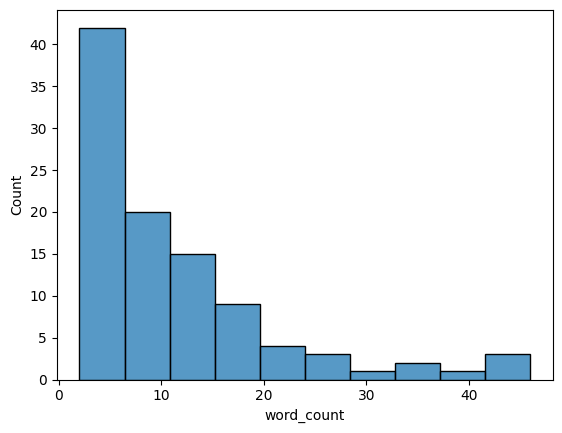

In [24]:
def get_word_count(text):
    words = text.split(" ")
    return len(words)

sample_df['word_count'] = sample_df['rawContent'].apply(get_word_count)

sns.histplot(data=sample_df["word_count"])

In [ ]:
sns.histplot(
    data=sample_df, 
    x="word_count", 
    hue='chatgpt_sentiment', 
    multiple='stack',
    palette='Set1',
    # element="poly"
)

In [ ]:
# Distribuição de word count segmentado pelo sentimento
fig, ax = plt.subplots(1, 3, figsize=(20, 4))

sns.histplot(
    data=sample_df[sample_df['chatgpt_sentiment'] == 'neg'], 
    x="word_count", 
    hue='chatgpt_sentiment', 
    discrete=True,
    ax=ax[0],
    kde=True,
    palette="Reds",
)

sns.histplot(
    data=sample_df[sample_df['chatgpt_sentiment'] == 'neu'], 
    x="word_count", 
    hue='chatgpt_sentiment', 
    discrete=True,
    palette='Greens',
    ax=ax[1],
    kde=True,
)

sns.histplot(
    data=sample_df[sample_df['chatgpt_sentiment'] == 'pos'], 
    x="word_count", 
    hue='chatgpt_sentiment', 
    discrete=True,
    palette='Blues',
    ax=ax[2],
    kde=True,
)

In [ ]:
sns.scatterplot(
    data=sample_df, 
    x="word_count", 
    y="abs_leia_error", 
    hue='chatgpt_sentiment', 
    palette='Set1'
)

## Salvando os resultados

In [ ]:
sample_df[:10]

In [ ]:
output_path = '../data/processed/'
output_file = f'sentiment_analysis_comparison_output.csv'

# Para salvar os dados, descomente as linhas abaixo
# sample_df.to_csv(f"{output_path}{output_file}", sep=';', encoding='utf-8', index=False)